In [18]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os
from tqdm import tqdm
from matplotlib.animation import FuncAnimation

In [19]:
# Constants
G = 9.81  # Gravity (m/s^2)
BOUNCE_COEFF = 0.9  # Coefficient of restitution (energy retention on bounce)

In [20]:
# Collision Handling
def handle_collisions(state, radius, box_size, bounce_coeff):
    """
    Correct position and velocity of the ball when it collides with a boundary.
    """
    x, vx, y, vy = state

    # Check and handle collisions with the left and right walls
    if x - radius < -box_size:  # Left wall
        x = -box_size + radius
        vx = -bounce_coeff * vx  # Reverse x velocity
    elif x + radius > box_size:  # Right wall
        x = box_size - radius
        vx = -bounce_coeff * vx  # Reverse x velocity

    # Check and handle collisions with the floor and ceiling
    if y - radius < -box_size:  # Floor
        y = -box_size + radius
        vy = -bounce_coeff * vy  # Reverse y velocity
    elif y + radius > box_size:  # Ceiling
        y = box_size - radius
        vy = -bounce_coeff * vy  # Reverse y velocity

    return np.array([x, vx, y, vy])

In [21]:
# Particle Dynamics
def particle_dynamics_with_collisions(t, y, mass, radius, box_size, drag_coeff, bounce_coeff):
    """
    Simulate the dynamics of a ball with gravity, air resistance, and proper collision handling.
    """
    # Unpack state variables
    x, vx, y_pos, vy = y
    dydt = np.zeros_like(y)

    # Update positions
    dydt[0] = vx  # dx/dt = vx
    dydt[2] = vy  # dy/dt = vy

    # Forces: Gravity and Air Resistance
    speed = np.sqrt(vx**2 + vy**2)  # Compute speed for drag calculation
    drag_force_x = -drag_coeff * speed * vx  # Drag force in x-direction
    drag_force_y = -drag_coeff * speed * vy  # Drag force in y-direction

    dydt[1] = drag_force_x / mass  # dvx/dt = Drag force in x / mass
    dydt[3] = (-G + drag_force_y / mass)  # dvy/dt = Gravity + drag force in y / mass

    return dydt

In [22]:
# Generate Dataset
def generate_ball_dataset(n_balls, dt, output_dir):
    """
    Generate a dataset of ball trajectories including air resistance and gravity.
    """
    os.makedirs(output_dir, exist_ok=True)
    dataset = []

    for i in tqdm(range(n_balls), desc="Generating dataset"):
        # Randomized parameters for mass, radius, initial velocity, and initial position
        mass = np.random.uniform(0.5, 5.0)  # Mass in kilograms
        radius = np.random.uniform(0.05, 0.2)  # Radius in meters
        box_size = 5.0  # Simulation box size (meters)
        drag_coeff = 0.1  # Drag coefficient (air resistance)
        bounce_coeff = 0.9  # Coefficient of restitution (bounciness)
        init_pos = np.random.uniform(-box_size + radius, box_size - radius, 2)
        init_vel = np.random.uniform(-5.0, 5.0, 2)  # Random initial velocity in x and y
        y0 = np.concatenate([init_pos, init_vel])  # [x, vx, y, vy]

        t_span = (0, 10)  # Simulate for 10 seconds
        t_eval = np.linspace(t_span[0], t_span[1], int(10 / dt))

        # Solve the ODE and handle collisions explicitly
        trajectory = []
        state = y0
        for t in t_eval:
            sol = solve_ivp(
                particle_dynamics_with_collisions,
                (t, t + dt),
                state,
                args=(mass, radius, box_size, drag_coeff, bounce_coeff),
                method='RK45',
                t_eval=[t + dt]
            )
            state = sol.y.flatten()  # Update state
            state = handle_collisions(state, radius, box_size, bounce_coeff)  # Handle collisions
            trajectory.append(state)

        trajectory = np.array(trajectory)

        # Generate GIF of the trajectory
        gif_path = os.path.join(output_dir, f"ball_{i}.gif")
        generate_ball_gif(trajectory, radius, box_size, gif_path)

        # Save dataset entry
        dataset.append((trajectory, mass, radius, box_size, drag_coeff, gif_path))

    return dataset

In [23]:
# Generate GIFs
def generate_ball_gif(trajectory, radius, box_size, save_path):
    """
    Generate a GIF visualizing the ball's trajectory in 2D.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-box_size, box_size)
    ax.set_ylim(-box_size, box_size)
    ax.set_aspect('equal')

    ball = plt.Circle((trajectory[0, 0], trajectory[0, 2]), radius, fc='blue')
    ax.add_patch(ball)

    def update(frame):
        ball.set_center((trajectory[frame, 0], trajectory[frame, 2]))
        return ball,

    ani = FuncAnimation(fig, update, frames=len(trajectory), blit=True, interval=50)
    ani.save(save_path, fps=20, writer='imagemagick')
    plt.close(fig)

Generating dataset:  63%|██████▎   | 63/100 [41:05<24:08, 39.14s/it]


KeyboardInterrupt: 

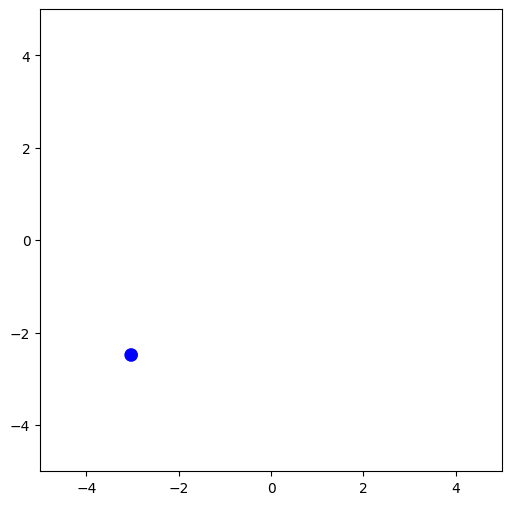

In [24]:
output_dir = "ball_dataset"
dt = 0.01
trajectories = generate_ball_dataset(100, dt, output_dir)

In [ ]:
# Define Dataset Class
class BallTrajectoryDataset(Dataset):
    def __init__(self, trajectories, seq_len, pred_len):
        self.trajectories = trajectories
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        trajectory = self.trajectories[idx]
        input_seq = trajectory[:self.seq_len]
        target_seq = trajectory[self.seq_len:self.seq_len + self.pred_len]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

In [ ]:
dataset = BallTrajectoryDataset(trajectories, seq_len, pred_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class SINDyKoopmanPINN(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, sparse_dim):
        super(SINDyKoopmanPINN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
        )

        # Koopman Operator
        self.koopman = nn.Linear(latent_dim, latent_dim, bias=False)

        # Sparse Dynamics (SINDy)
        self.sindy_dynamics = nn.Linear(latent_dim, sparse_dim, bias=False)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        z_next = self.koopman(z)
        dzdt = self.sindy_dynamics(z)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z_next, dzdt, z

In [ ]:
# Loss Functions
def compute_energy(state, mass, g):
    vx, vy = state[:, 1], state[:, 3]
    y = state[:, 2]
    kinetic_energy = 0.5 * mass * (vx**2 + vy**2)
    potential_energy = mass * g * y
    return kinetic_energy + potential_energy

def physics_informed_loss(predictions, targets, mass, g):
    predicted_energy = compute_energy(predictions, mass, g)
    target_energy = compute_energy(targets, mass, g)
    return torch.mean((predicted_energy - target_energy)**2)

def combined_loss(x_reconstructed, x_target, z_next, dzdt, dzdt_target, mass, g, alpha=0.1, beta=0.1, gamma=0.1):
    reconstruction_loss = torch.mean((x_reconstructed - x_target)**2)
    koopman_loss = torch.mean((z_next - dzdt_target)**2)
    sparse_loss = torch.mean((dzdt - dzdt_target)**2)
    energy_loss = physics_informed_loss(x_reconstructed, x_target, mass, g)
    return reconstruction_loss + alpha * energy_loss + beta * koopman_loss + gamma * sparse_loss

In [ ]:
# Training Loop
def train_sindy_koopman_pinn(model, dataloader, optimizer, mass, g, num_epochs, alpha, beta, gamma):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            x_reconstructed, z_next, dzdt, z = model(inputs)
            dzdt_target = torch.diff(z, dim=1, prepend=torch.zeros_like(z[:, :1, :])) / (1.0 / 30.0)
            loss = combined_loss(x_reconstructed, targets, z_next, dzdt, dzdt_target, mass, g, alpha, beta, gamma)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader)}")

In [ ]:
seq_len = 80
pred_len = 20
latent_dim = 16
hidden_dim = 64
sparse_dim = 8
num_epochs = 100
batch_size = 16
learning_rate = 1e-3
alpha, beta, gamma = 0.1, 0.1, 0.1
mass = 1.0
g = G

In [ ]:
model = SINDyKoopmanPINN(input_dim=4, latent_dim=latent_dim, hidden_dim=hidden_dim, sparse_dim=sparse_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_sindy_koopman_pinn(model, dataloader, optimizer, mass, g, num_epochs, alpha, beta, gamma)